In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
# rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
from matplotlib import font_manager, rc
font_path = 'C:/Windows/Fonts/malgun.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import missingno as msno # 결측치를 확인할 수 있는 라이브러리
import os
import sys

# 경고 문구 off
import warnings
warnings.filterwarnings('ignore')

# 컬럼 표시 제한
# pd.set_option('display.max_row', None)
pd.set_option('display.max_columns', None)

# 1. 상황인식

1.배경

안녕하세요 여러분! 구내식당 식수 인원 예측 AI 경진대회에 오신 것을 환영합니다.

지금까지는 단순한 시계열 추세와 담당자의 직관적 경험에 의존하여한국토지주택공사 구내식당 식수 인원을 예측하였으나,

빅데이터 분석으로 얻어지는 보다 정확도 높은 예측을 통해 "잔반 발생량을 획기적으로 줄이고자" 합니다.

 
2.목적

구내식당의 요일별 점심, 저녁식사를 먹는 인원을 예측

___________________________________________________________________________________________________________________


3.	평가

평가산식 : MAE(Mean Absolute Error)
Public 평가 : 전체 Test 데이터 중 무작위 30 % (15일)
Private 평가 : 전체 Test 데이터 중 나머지 70 % (35일)


4. 외부 데이터 및 사전학습 모델

공공 데이터와 같이 누구나 얻을 수 있고 법적 제약이 없는 외부 데이터 허용
사전학습 모델의 경우 사전학습에 사용된 데이터를 명시해야함
최종 평가시 외부데이터 및 출처 제출


5. 코드 평가

다음 조건을 만족하며 제출한 코드로 Private score가 복원된 상위 3팀에게 상금을 수여합니다.
조건 1. Private 순위 공개 후 코드 제출 기간 내 코드 코드공유 게시판 게시한 팀(설명 PPT dacon@dacon.io로 제출)
			제목 양식 : 팀이름, Private 순위와 Private 점수, 모델 이름

			내 용 : 전처리, 학습, 후처리, 추론 일련의 과정을 담은 코드를 게시

			예시) 데이콘팀, Private 1위, Private 점수 : 5.23, ResNet

# 2. 데이터 분석

>## 1) 데이터 불러오기

In [2]:
train_df = pd.read_csv('restaurant/train.csv')
train_df.head(1)


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0


In [3]:
test_df = pd.read_csv('restaurant/test.csv')
test_df.head(1)

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021-01-27,수,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치


In [4]:
submission_df = pd.read_csv('restaurant/sample_submission.csv')
submission_df.head()

,일자,중식계,석식계
0,2021-01-27,0,0
1,2021-01-28,0,0
2,2021-01-29,0,0
3,2021-02-01,0,0
4,2021-02-02,0,0


### 컬럼정리

In [5]:
train_df['일자'] = train_df['일자'].str.replace('-', '')
train_df.insert(0, 'date', train_df['일자'].str[2:8])
train_df.insert(1, 'year', train_df['일자'].str[:4])
train_df.insert(2, 'month', train_df['일자'].str[4:6])
train_df.insert(3, 'day', train_df['일자'].str[6:])
train_df.columns=['date','year','month','day','일자','요일','정원','휴가자','출장자','시간외근무','재택근무','조식','중식','석식','중식계','석식계']
train_df.insert(11, '근무중인원', train_df['정원']-train_df['휴가자']-train_df['출장자']+train_df['시간외근무']-train_df['재택근무'])

train_df.head(1)

,date,year,month,day,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,근무중인원,조식,중식,석식,중식계,석식계
0,160201,2016,02,01,20160201,월,2601,50,150,238,0.0,2639.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0


In [6]:
train_df['재택근무'] = train_df['재택근무'].astype(int)
train_df['중식계'] = train_df['중식계'].astype(int)
train_df['석식계'] = train_df['석식계'].astype(int)
train_df.head(1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1205 non-null   object 
 1   year    1205 non-null   object 
 2   month   1205 non-null   object 
 3   day     1205 non-null   object 
 4   일자      1205 non-null   object 
 5   요일      1205 non-null   object 
 6   정원      1205 non-null   int64  
 7   휴가자     1205 non-null   int64  
 8   출장자     1205 non-null   int64  
 9   시간외근무   1205 non-null   int64  
 10  재택근무    1205 non-null   int32  
 11  근무중인원   1205 non-null   float64
 12  조식      1205 non-null   object 
 13  중식      1205 non-null   object 
 14  석식      1205 non-null   object 
 15  중식계     1205 non-null   int32  
 16  석식계     1205 non-null   int32  
dtypes: float64(1), int32(3), int64(4), object(9)
memory usage: 146.0+ KB


In [7]:
test_df['일자'] = test_df['일자'].str.replace('-', '')
test_df.insert(0, 'date', test_df['일자'].str[2:8])
test_df.columns=['date','일자','요일','정원','휴가자','출장자','시간외근무','재택근무','조식','중식','석식']
test_df.insert(8, '근무중인원', test_df['정원']-test_df['휴가자']-test_df['출장자']+test_df['시간외근무']-test_df['재택근무'])

test_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,근무중인원,조식,중식,석식
0,210127,20210127,수,2983,88,182,5,358.0,2360.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치


In [8]:
test_df['재택근무'] = train_df['재택근무'].astype(int)
test_df.head(1)

,date,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,근무중인원,조식,중식,석식
0,210127,20210127,수,2983,88,182,5,0,2360.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    50 non-null     object 
 1   일자      50 non-null     object 
 2   요일      50 non-null     object 
 3   정원      50 non-null     int64  
 4   휴가자     50 non-null     int64  
 5   출장자     50 non-null     int64  
 6   시간외근무   50 non-null     int64  
 7   재택근무    50 non-null     int32  
 8   근무중인원   50 non-null     float64
 9   조식      50 non-null     object 
 10  중식      50 non-null     object 
 11  석식      50 non-null     object 
dtypes: float64(1), int32(1), int64(4), object(6)
memory usage: 4.6+ KB


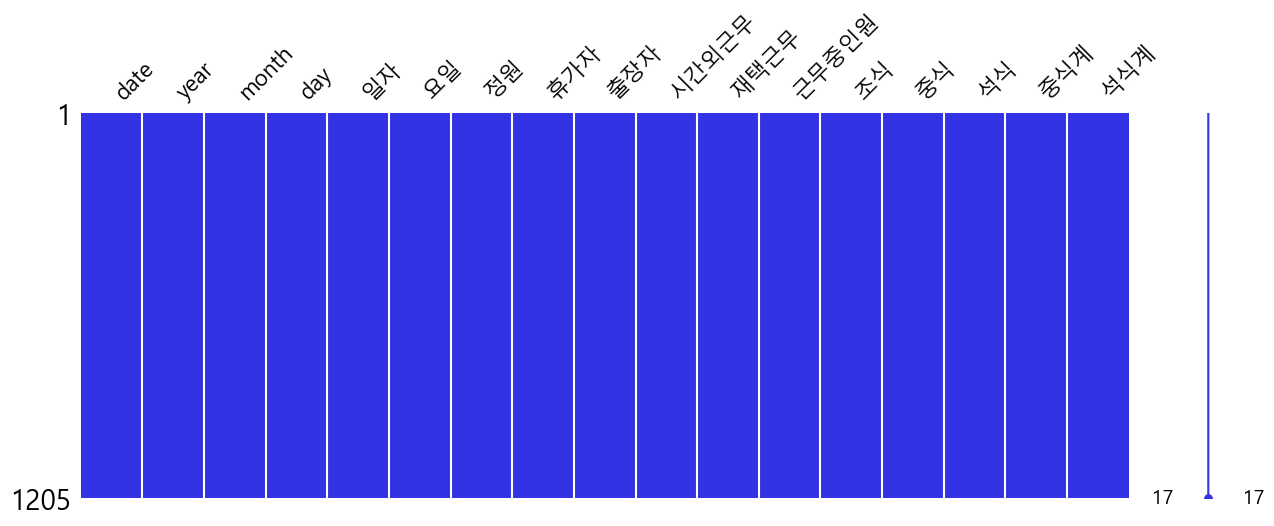

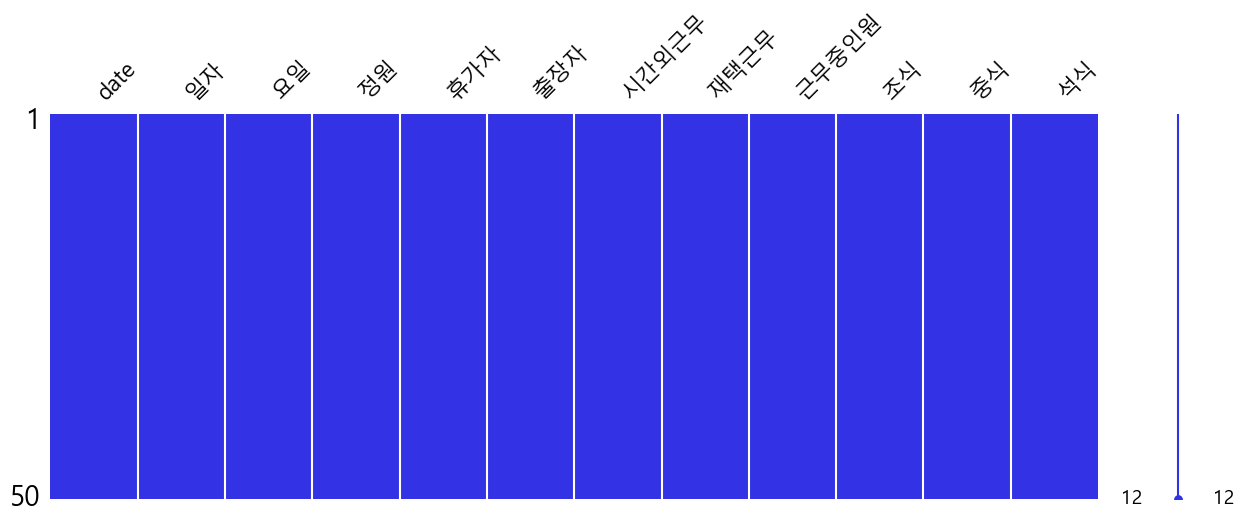

In [10]:
msno.matrix(df=train_df.iloc[:, :], color=(0.2, 0.2, 0.9), figsize=(15, 5));
msno.matrix(df=test_df.iloc[:, :], color=(0.2, 0.2, 0.9), figsize=(15, 5));

### 텍스트 정리

In [11]:
import re

def split_text(stringData):

    text = re.sub(r'\([^)]*\)', repl='', string=stringData)        
    text = text.replace('/',' ')
    text = text.replace('  ',' ')
    text = text.replace('*',' ')
    return text

In [12]:
train_df['조식'] = train_df['조식'].apply(split_text)
train_df['중식'] = train_df['중식'].apply(split_text)
train_df['석식'] = train_df['석식'].apply(split_text)

test_df['조식'] = train_df['조식'].apply(split_text)
test_df['중식'] = train_df['중식'].apply(split_text)
test_df['석식'] = train_df['석식'].apply(split_text)

print(train_df['조식'][0])
print(train_df['중식'][0])
print(train_df['석식'][0])
print()
print(test_df['조식'][0])
print(test_df['중식'][0])
print(test_df['석식'][0]) 

모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치 
쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치 
쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치 

모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치 
쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치 
쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치 


In [13]:
morning_menu_list = []
lunch_menu_list = []
dinner_menu_list = []

for i in train_df['조식']:
    tmp_data = i.split(' ')
    #print(tmp_data)
    for j in tmp_data:
        morning_menu_list.append(j)
        
for i in train_df['중식']:
    tmp_data = i.split(' ')
    #print(tmp_data)
    for j in tmp_data:
        lunch_menu_list.append(j)
        
for i in train_df['석식']:
    tmp_data = i.split(' ')
    #print(tmp_data)
    for j in tmp_data:
        dinner_menu_list.append(j)
        
morning_menu_list[0]

'모닝롤'

In [14]:
type(morning_menu_list)

list

In [15]:
list(set(morning_menu_list))

['',
 '메추리알곤약조림',
 '취나물된장무침',
 '멸치캐슈넛볶음',
 '매운사태조림',
 '누룽지',
 '크랜베리멸치볶음',
 '느타리버섯장조림',
 '사과베이비샐러드',
 '깍두기',
 '가자미양념찜',
 '에그타르트',
 '허니브레드',
 '쥐어채무침',
 '진미채볶음',
 '우엉땅콩조림',
 '봄동나물',
 '콩자반',
 '새알만두국',
 '선지해장국',
 '버섯들깨죽',
 '계란장조림',
 '지리멸치볶음',
 '건새우무채국',
 '모닝롤',
 '바지락콩나물국',
 '얼큰낙지죽',
 '호박채나물',
 '시금치프리타타',
 '두부브로컬리무침',
 '비름나물',
 '우엉조림',
 '콩나물무침',
 '마늘빵',
 '볼어묵볶음',
 '숙주미나리나물',
 '시금치나물무침',
 '도라지나물',
 '수제어묵볶음',
 '김실파무침',
 '핫케익',
 '카레감자볶음',
 '카스테라',
 '고구마죽',
 '해물죽',
 '마늘쫑맛살볶음',
 '깻잎순볶음',
 '올갱이아욱국',
 '베이컨치즈베이글',
 '감자채볶음',
 '피바지락국',
 '방풍나물',
 '씨크립샌드',
 '곤약어묵볶음',
 '새알미역국',
 '소고기미역국',
 '새우완자국',
 '고구마순볶음',
 '소보루빵',
 '구운어묵볶음',
 '참치김치볶음',
 '소고기무국',
 '돈육장조림',
 '브로컬리된장무침',
 '게살모닝샌드위치',
 '단호박샌드',
 '냉이국',
 '메추리알조림',
 '홍초콩나물국',
 '마늘종숙회',
 '매운콩나물국',
 '땅콩죽',
 '비엘티샌드위치',
 '동전문어조림',
 '치즈팡샌드',
 '사각어묵볶음',
 '명엽채고추장볶음',
 '해물완자전',
 '명엽체고추장볶음',
 '고구마샌드',
 '핫케이크',
 '머위대나물',
 '쌀밥',
 '갈릭파이',
 '구이김',
 '맑은콩나물국',
 '고르곤졸라',
 '단호박죽',
 '우거지국',
 '감자찌개',
 '브로컬리두부무침',
 '쇠고기무국',
 '에그포테이토샌드위치',
 '북어맑은국',
 '바지락살국',
 '시금치나물',
 '맑은연두부

In [16]:
len(morning_menu_list)

13507

In [17]:
len(list(set(morning_menu_list)))

787

In [18]:
lunch_menu_list[1]

'잡곡밥'

In [19]:
dinner_menu_list[2]

'육개장'

In [20]:
train_df.head(10)

,date,year,month,day,일자,요일,정원,휴가자,출장자,시간외근무,재택근무,근무중인원,조식,중식,석식,중식계,석식계
0,160201,2016,02,01,20160201,월,2601,50,150,238,0,2639.0,모닝롤 찐빵 우유 두유 주스 계란후라이 호두죽 쌀밥 된장찌개 쥐어채무침 포기김치,쌀밥 잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥 잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치,1039,331
1,160202,2016,02,02,20160202,화,2601,50,173,319,0,2697.0,모닝롤 단호박샌드 우유 두유 주스 계란후라이 팥죽 쌀밥 호박젓국찌개 시래기조림 포기김치,쌀밥 잡곡밥 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉절이,콩나물밥 양념장 어묵국 유산슬 아삭고추무침 바나나 포기김치,867,560
2,160203,2016,02,03,20160203,수,2601,56,180,111,0,2476.0,모닝롤 베이글 우유 두유 주스 계란후라이 표고버섯죽 쌀밥 콩나물국 느타리호박볶음 포...,카레덮밥 팽이장국 치킨핑거 쫄면야채무침 견과류조림 요구르트 포기김치,쌀밥 잡곡밥 청국장찌개 황태양념구이 고기전 새송이버섯볶음 포기김치,1017,573
3,160204,2016,02,04,20160204,목,2601,104,220,355,0,2632.0,모닝롤 토마토샌드 우유 두유 주스 계란후라이 닭죽 쌀밥 근대국 멸치볶음 포기김치,쌀밥 잡곡밥 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트 포기김치,미니김밥 겨자장 우동 멕시칸샐러드 군고구마 무피클 포기김치,978,525
4,160205,2016,02,05,20160205,금,2601,278,181,34,0,2176.0,모닝롤 와플 우유 두유 주스 계란후라이 쇠고기죽 쌀밥 재첩국 방풍나물 포기김치,쌀밥 잡곡밥 떡국 돈육씨앗강정 우엉잡채 청경채무침 요구르트 포기김치,쌀밥 잡곡밥 차돌박이찌개 닭갈비 감자소세지볶음 콩나물무침 포기김치,925,330
5,160211,2016,02,11,20160211,목,2601,383,143,417,0,2492.0,팬케익 찐빵 우유 두유 주스 계란후라이 견과류죽 쌀밥 감자찌개 명엽채무침 포기김치,쌀밥 잡곡밥 시래기국 훈제오리구이 도토리묵무침 쌈무 양파절임 요구르트 포기김치,참치회덮밥 맑은국 군만두 과일샐러드 락교 포기김치,1045,550
6,160212,2016,02,12,20160212,금,2601,389,156,93,0,2149.0,모닝롤 야채샌드 우유 두유 주스 계란후라이 고구마죽 쌀밥 봄동된장국 숙주나물 포기김치,쌀밥 잡곡밥 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 요구르트 포기김치,쌀밥 잡곡밥 김치콩나물국 미니함박 어묵볶음 물파래무침 깍두기,909,598
7,160215,2016,02,15,20160215,월,2601,87,204,482,0,2792.0,모닝롤 치즈프레즐 우유 두유 주스 계란후라이 잣죽 쌀밥 민물새우찌개 콩조림 포기김치,쌀밥 잡곡밥 시금치국 닭감자조림 연두부 양념장 콩나물무침 요구르트 포기김치,쌀밥 잡곡밥 홍합미역국 등갈비김치찜 임연수구이 브로컬리초장 포기김치,1268,672
8,160216,2016,02,16,20160216,화,2601,72,236,526,0,2819.0,모닝롤 마늘빵 우유 두유 주스 계란후라이 단호박죽 쌀밥 어묵국 김구이 포기김치,쌀밥 잡곡밥 쇠고기무국 탕수어 오징어숙회무침 취나물 요구르트 포기김치,쌀밥 잡곡밥 된장찌개 쇠불고기 해파리겨자채 봄동무침 포기김치,1014,523
9,160217,2016,02,17,20160217,수,2601,78,250,23,0,2296.0,모닝롤 참치샌드 우유 두유 주스 계란후라이 흑임자죽 쌀밥 북어계란국 무생채 포기김치,쌀밥 잡곡밥 냉이된장국 쇠고기장조림 통도라지구이 치커리무침 요구르트 포기김치,볶음밥 자장소스 맑은국 새우또띠아 쨔샤이무침 요플레 포기김치,916,588


# EDA

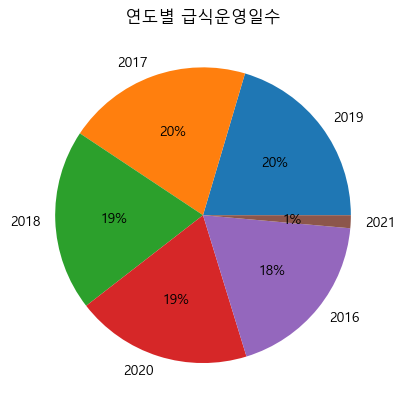

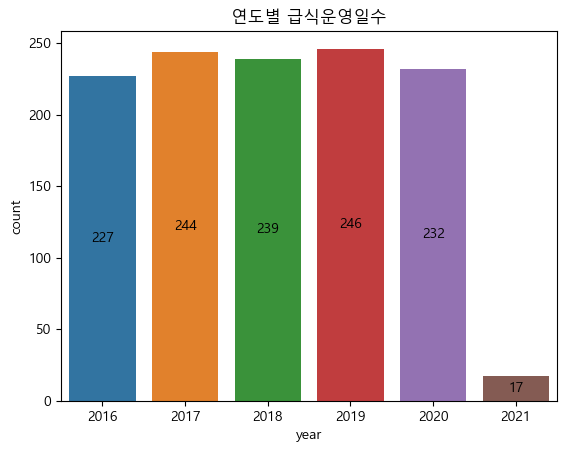

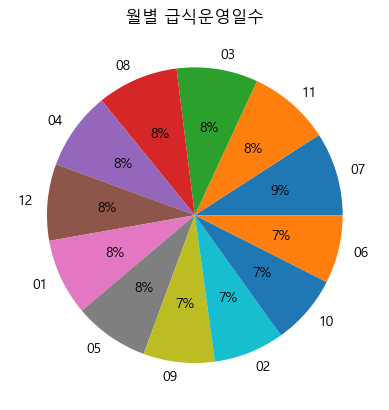

In [35]:
train_df["year"].value_counts()
plt.pie(train_df["year"].value_counts().values, labels=train_df["year"].value_counts().index, autopct="%d%%")
plt.title('연도별 급식운영일수')
plt.show()

ax = sns.countplot(x = 'year',data = train_df)
containers = ax.containers[0]
ax.bar_label(containers, labels=[f'{x:,.0f}' for x in containers.datavalues], label_type='center')
plt.title('연도별 급식운영일수')
plt.show()

train_df["month"].value_counts()
plt.pie(train_df["month"].value_counts().values, labels=train_df["month"].value_counts().index, autopct="%d%%")
plt.title('월별 급식운영일수')
plt.show()


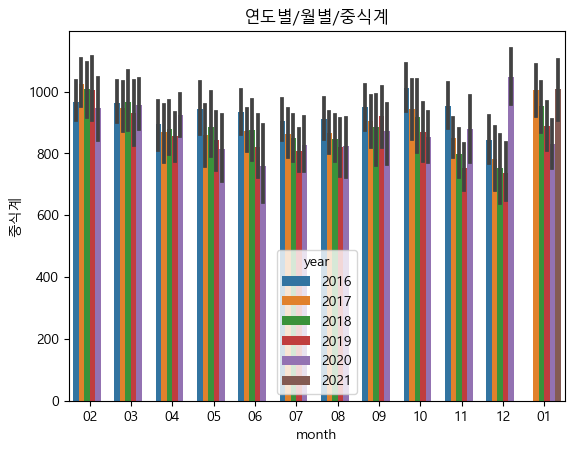

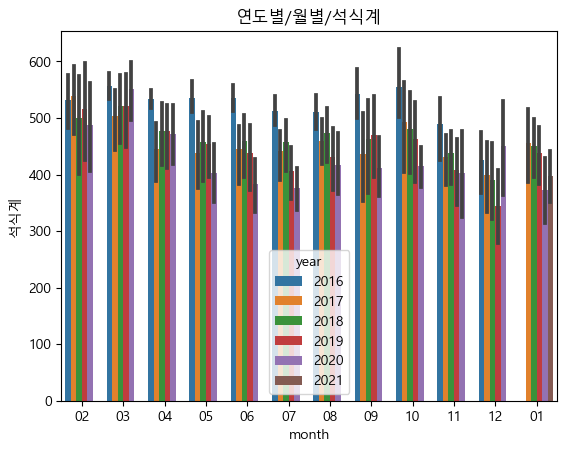

In [40]:
ax = sns.barplot(data=train_df, x='month', y="중식계", hue='year')
plt.title('연도별/월별/중식계')
plt.show()

ax = sns.barplot(data=train_df, x='month', y="석식계", hue='year')
plt.title('연도별/월별/석식계')
plt.show()


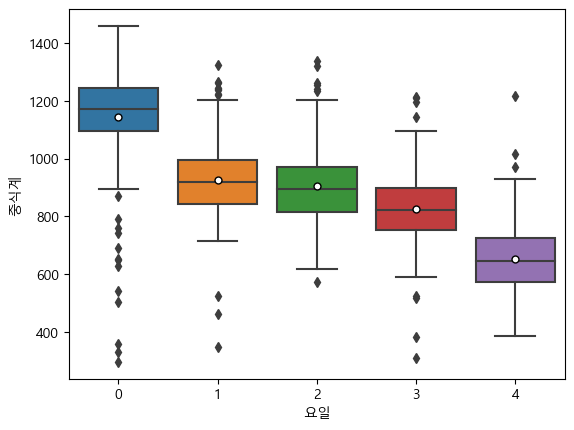

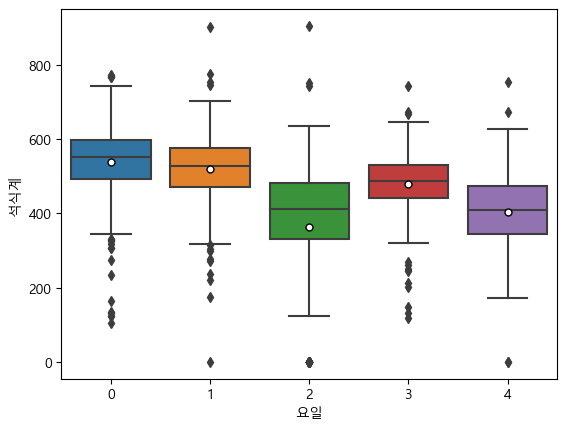

In [39]:
sns.boxplot(data=train_df, y="중식계", x="요일",showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})
plt.show()
sns.boxplot(data=train_df, y="석식계", x="요일",showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black","markersize":"5"})
plt.show()

In [47]:
train_df['중식'][1201]

# 조식은 조식계 없어서 뺴기, 쌀밥/덮밥여부, 요구르트,김치는 빼도될듯, 0과 1 이후인덱스는 무조건 국.

'쌀밥 수수밥 찰현미밥 냉이된장국 동파육 봄동전 청경채 버섯숙회 초장 무생채 양상추샐러드 파인D '

In [24]:
train_df.columns

Index(['date', 'year', 'month', 'day', '일자', '요일', '정원', '휴가자', '출장자', '시간외근무',
       '재택근무', '근무중인원', '조식', '중식', '석식', '중식계', '석식계'],
      dtype='object')

In [25]:
train_df['요일'] = train_df['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})
test_df['요일'] = test_df['요일'].map({'월':0, '화':1, '수':2, '목':3, '금':4})


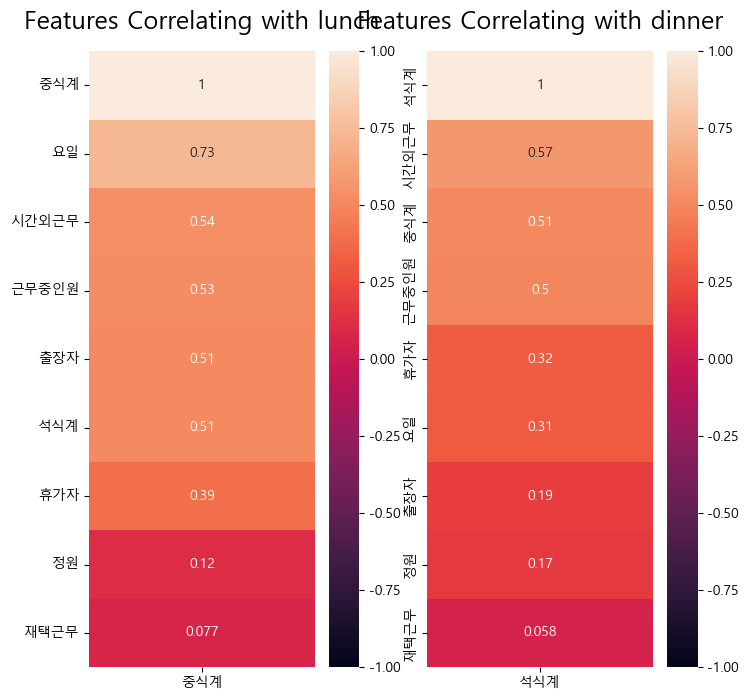

<Figure size 300x800 with 0 Axes>

In [31]:
figure, ((ax1,ax2)) = plt.subplots(nrows = 1, ncols = 2)
figure.set_size_inches (8, 8)

heatmap = sns.heatmap(train_df.corr().abs()[['중식계']].sort_values(by='중식계',ascending=False), vmin=-1, vmax=1,annot=True, ax=ax1)
heatmap.set_title('Features Correlating with lunch', fontdict={'fontsize':18}, pad=16);
plt.figure(figsize=(3, 8))
heatmap = sns.heatmap(train_df.corr().abs()[['석식계']].sort_values(by='석식계',ascending=False), vmin=-1, vmax=1,annot=True, ax=ax2)
heatmap.set_title('Features Correlating with dinner', fontdict={'fontsize':18}, pad=16);


In [32]:
train_df2 = train_df(train_df['date','year'])
train_df2

KeyError: ('date', 'year')